In [1]:
import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
#Load data and put into train and test sets
X, y = cp.load(open('winequality-white.pickle', 'rb'))
N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

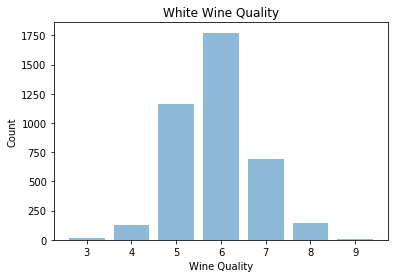

In [3]:
#Create a bar chart for training output data
objects = (3, 4, 5, 6, 7, 8, 9)
y_pos = np.arange(len(objects))
performance = [np.count_nonzero(y_train == 3),
               np.count_nonzero(y_train == 4),
               np.count_nonzero(y_train == 5),
               np.count_nonzero(y_train == 6),
               np.count_nonzero(y_train == 7),
               np.count_nonzero(y_train == 8),
               np.count_nonzero(y_train == 9)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('White Wine Quality')

plt.show()

In [4]:
#Calculate MSE for simplest model (average of all outputs)
mean_y_train = np.mean(y_train)
MSE = (np.sum((mean_y_train - y_train)**2)) / len(y_train)

MSE

0.7767772386501117

In [5]:
#Standardize both training and testing features
scaler = StandardScaler().fit(X_train)
X_train_stand = scaler.transform(X_train)

X_test_stand = scaler.transform(X_test)

In [6]:
#Use w = (x^T X)^-1 X^T y for least squares linear regression
XT = X_train_stand.transpose()

XTX = np.matmul(XT, X_train_stand)

XTX_inv = np.linalg.inv(XTX)

w = np.matmul(np.matmul(XTX_inv, XT), y_train)

In [7]:
#Get MSE on training set
y_hat_train = np.matmul(X_train_stand, w) + np.mean(y_train)

MSE_train = (np.sum((y_hat_train - y_train)**2)) / len(y_train)
MSE_train

0.5639996173941925

In [8]:
#Get MSE on testing set
y_hat_test = np.matmul(X_test_stand, w) + np.mean(y_train)

MSE_test = (np.sum((y_hat_test - y_test)**2)) / len(y_test)
MSE_test

0.56072920422927

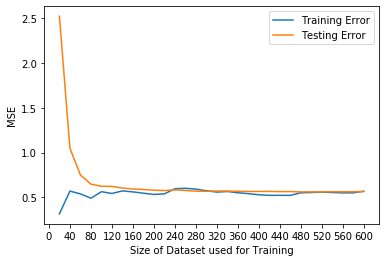

In [9]:
#Learning curve
train_error = []
test_error = []

for N_train in range(20, 620, 20):
    #Split training and testing data
    X_train = X[:N_train]
    y_train = y[:N_train]
    #X_test = X[N_train:]
    #y_test = y[N_train:]
    
    #Standardize data
    scaler = StandardScaler().fit(X_train)
    X_train_stand = scaler.transform(X_train)
    X_test_stand = scaler.transform(X_test)
    
    #Train data
    XT = X_train_stand.transpose()
    XTX = np.matmul(XT, X_train_stand)
    XTX_inv = np.linalg.inv(XTX)
    w = np.matmul(np.matmul(XTX_inv, XT), y_train)
    
    #Get MSE on training set
    y_hat_train = np.matmul(X_train_stand, w) + np.mean(y_train)
    MSE_train = (np.sum((y_hat_train - y_train)**2)) / len(y_train)
    train_error.append(MSE_train)
    
    #Get MSE on testing set
    y_hat_test = np.matmul(X_test_stand, w) + np.mean(y_train)
    MSE_test = (np.sum((y_hat_test - y_test)**2)) / len(y_test)
    test_error.append(MSE_test)
    
#Plot errors
train_error_plot, = plt.plot(range(20, 620, 20), train_error, label='Training Error')
test_error_plot, = plt.plot(range(20, 620, 20), test_error, label='Testing Error')
plt.legend(handles=[train_error_plot, test_error_plot])
plt.xlabel('Size of Dataset used for Training')
plt.ylabel('MSE')
plt.xticks(range(0, 620, 40))
plt.show()

Since the training and testing error curves level off at roughly the same value, it appears this model is not underfitting. It appears you only need a training set size of around 150 data points before the testing error becomes adequate. More data points appears to produce improvement to testing error with no signs of overfitting, but these improvements are incredibly small.

In [10]:
#Re-Load data and put into train and test sets
X, y = cp.load(open('winequality-white.pickle', 'rb'))
N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

In [11]:
#Split training into training and validation sets
N = int(len(X_train) * 0.8)
X_train_ridge = X_train[:N]
y_train_ridge = y_train[:N]
X_valid_ridge = X_train[N:]
y_valid_ridge = y_train[N:]

In [12]:
#Get degree 2 basis expansion
poly = PolynomialFeatures(2)
X_train_ridge_poly = poly.fit_transform(X_train_ridge)
X_valid_ridge_poly = poly.fit_transform(X_valid_ridge)

#Loop to find best lambda
best_lambda = -1
best_error = 1000
for l in [0.01, 0.1, 1, 10, 100]:
    #Create pipeline
    pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=l))])
    pipe.fit(X_train_ridge_poly, y_train_ridge)
    error = (np.sum((pipe.predict(X_valid_ridge_poly) - y_valid_ridge)**2)) / len(y_valid_ridge)
    
    if error < best_error:
        best_lambda = l
        best_error = error
        
best_lambda

0.01

In [13]:
#Repeat steps for Lasso
#Split training into training and validation sets
N = int(len(X_train) * 0.8)
X_train_lasso = X_train[:N]
y_train_lasso = y_train[:N]
X_valid_lasso = X_train[N:]
y_valid_lasso = y_train[N:]

In [14]:
#Get degree 2 basis expansion
poly = PolynomialFeatures(2)
X_train_lasso_poly = poly.fit_transform(X_train_lasso)
X_valid_lasso_poly = poly.fit_transform(X_valid_lasso)

#Loop to find best lambda
best_lambda = -1
best_error = 1000
for l in [0.01, 0.1, 1, 10, 100]:
    #Create pipeline
    pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=l))])
    pipe.fit(X_train_lasso_poly, y_train_lasso)
    error = (np.sum((pipe.predict(X_valid_lasso_poly) - y_valid_lasso)**2)) / len(y_valid_lasso)
    
    if error < best_error:
        best_lambda = l
        best_error = error
        
best_lambda

0.01

In [15]:
#Get training and testing error on full data sets for Ridge
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Ridge(alpha=0.01))])
pipe.fit(X_train_poly, y_train)
    
train_error_ridge = (np.sum((pipe.predict(X_train_poly) - y_train)**2)) / len(y_train)
test_error_ridge = (np.sum((pipe.predict(X_test_poly) - y_test)**2)) / len(y_test)

[train_error_ridge, test_error_ridge]

[0.5014354471429413, 0.5161138844985498]

In [16]:
#Get training and testing error on full data sets for Lasso
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.01))])
pipe.fit(X_train_poly, y_train)
    
train_error_lasso = (np.sum((pipe.predict(X_train_poly) - y_train)**2)) / len(y_train)
test_error_lasso = (np.sum((pipe.predict(X_test_poly) - y_test)**2)) / len(y_test)

[train_error_lasso, test_error_lasso]

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6575181351659012, tolerance: 0.304341322103114
  positive)


[0.5489433346501358, 0.542231437143067]